Introducción:
Este problema radica en identificar la elección del rival en el clásico juego de piedra, papel o tijeras. Si bien es un dataset relativamente sencillo y de poco uso en la vida cotidiana, esta red podría ser usada para ir prediciendo en tiempo real lo que el rival está haciendo. Mientras va el rival eligiendo, el modelo podría predecir lo que puede poner basado en el amplio set de datos con el que fue entrenado. Ya que pueden existir variaciones en cómo alguien hace cada tirada y si al final la hicieron a medias o no, el modelo podría ser capaz (en teoría) de identificar los pasos que sigue la mano para representar cada figura. 

In [18]:
!pip install kaggle

In [3]:
# Se descarga el dataset de Rock, Paper, Scissors (incluye una carpeta de imagenes para cada clase dividido en train, test y validation)
import os

os.environ['KAGGLE_CONFIG_DIR'] = "kaggle.json"

!kaggle datasets download -d sanikamal/rock-paper-scissors-dataset

Dataset URL: https://www.kaggle.com/datasets/sanikamal/rock-paper-scissors-dataset
License(s): other




  0%|          | 0.00/452M [00:00<?, ?B/s]
  0%|          | 1.00M/452M [00:00<01:28, 5.32MB/s]
  0%|          | 2.00M/452M [00:00<01:10, 6.74MB/s]
  1%|          | 4.00M/452M [00:00<00:53, 8.72MB/s]
  1%|▏         | 6.00M/452M [00:00<00:50, 9.26MB/s]
  2%|▏         | 8.00M/452M [00:00<00:48, 9.62MB/s]
  2%|▏         | 9.00M/452M [00:01<00:50, 9.29MB/s]
  2%|▏         | 11.0M/452M [00:01<00:46, 10.0MB/s]
  3%|▎         | 12.0M/452M [00:01<00:45, 10.1MB/s]
  3%|▎         | 13.0M/452M [00:01<00:50, 9.04MB/s]
  3%|▎         | 15.0M/452M [00:01<00:47, 9.64MB/s]
  4%|▍         | 17.0M/452M [00:01<00:44, 10.3MB/s]
  4%|▍         | 18.0M/452M [00:01<00:44, 10.2MB/s]
  4%|▍         | 19.0M/452M [00:02<00:49, 9.15MB/s]
  4%|▍         | 20.0M/452M [00:02<00:49, 9.12MB/s]
  5%|▍         | 22.0M/452M [00:02<00:46, 9.72MB/s]
  5%|▌         | 23.0M/452M [00:02<00:54, 8.31MB/s]
  6%|▌         | 25.0M/452M [00:02<00:47, 9.47MB/s]
  6%|▌         | 27.0M/452M [00:03<00:44, 9.97MB/s]
  6%|▋         | 29.

In [ ]:
# Extraer contenido
import zipfile
with zipfile.ZipFile("RPS.zip", "r") as zip_ref:
    zip_ref.extractall("RPS")

In [ ]:
# Asignar datasets de train, valid y test
import os, shutil, pathlib
from keras.utils import image_dataset_from_directory

base_dir = pathlib.Path("C:/Tec/Semestre 7/AI 1/ComputerVision/RPS/Rock-Paper-Scissors")

train_dataset = image_dataset_from_directory(
    base_dir / "train",
    image_size=(300, 300),
    batch_size=32)

validation_dataset = image_dataset_from_directory(
    base_dir / "test",
    image_size=(300, 300),
    batch_size=32)

# Como las imagenes en la carpeta de validation no venían asignadas por clases, se hizo una carpeta para cada una
os.makedirs(base_dir/'validation/paper', exist_ok=True)
os.makedirs(base_dir/'validation/scissors', exist_ok=True)
os.makedirs(base_dir/'validation/rock', exist_ok=True)

validation_dir = base_dir / "validation"
for image in validation_dir.iterdir():
    if image.is_file():
        if 'paper' in image.stem.lower():
            shutil.move(str(image), str(base_dir / 'validation' / 'paper' / image.name))
        elif 'scissors' in image.stem.lower():
            shutil.move(str(image), str(base_dir / 'validation' / 'scissors' / image.name))
        elif 'rock' in image.stem.lower(): 
            shutil.move(str(image), str(base_dir / 'validation' / 'rock' / image.name))

test_dataset = image_dataset_from_directory(
    base_dir / "validation",
    image_size=(300, 300),
    batch_size=32)

Found 2520 files belonging to 3 classes.
Found 372 files belonging to 3 classes.
Found 33 files belonging to 3 classes.


In [76]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

np.random.seed(42)
tf.random.set_seed(42)

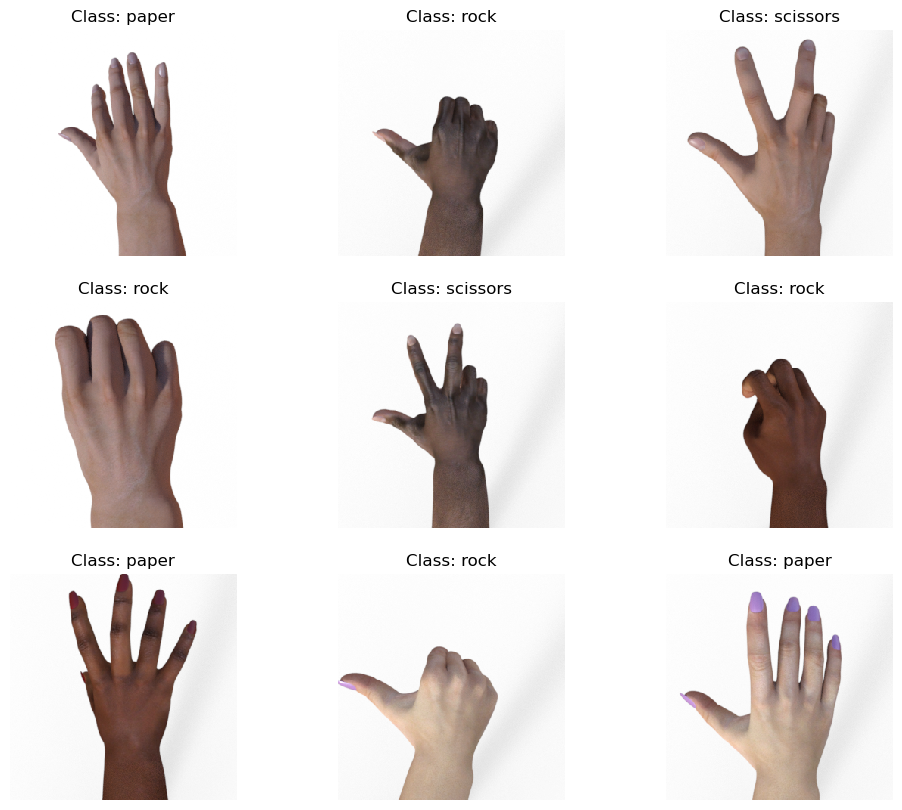

In [ ]:
# Visualización de algunas fotos y sus posibles clases
class_names = ['paper', 'rock', 'scissors']

plt.figure(figsize=(12, 10))
index = 0
for element in train_dataset.take(1):
  for i in range(9):
    image = element[0][i]
    label = element[1][i]
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image/255, interpolation="nearest")
    plt.title("Class: {}".format(class_names[int(label.numpy())]))
    plt.axis("off")

In [143]:
# Para el primer modelo decidí usar 4 capas convolucionales, usando batchnormalization antes de la activación con Relu, maxpooling y L2 regularization de .001. Usé un dropout de 0.6.
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
model1 = models.Sequential([
    layers.InputLayer(input_shape=(300, 300, 3)),  
    
    layers.Conv2D(32, (3, 3), kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(256, (3, 3), kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    
    layers.Dropout(0.6),
    
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)), 
    
    layers.Dense(3, activation='softmax')  
])

model1.summary()

c:\Users\dgzur\miniconda3\envs\ml_env\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_42 (Conv2D)              │ (None, 298, 298, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 298, 298, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_12 (ReLU)                 │ (None, 298, 298, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_42 (MaxPooling2D) │ (None, 149, 149, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 147, 147, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 147, 147, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_13 (ReLU)                 │ (None, 147, 147, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_43 (MaxPooling2D) │ (None, 73, 73, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 71, 71, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 71, 71, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_14 (ReLU)                 │ (None, 71, 71, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_44 (MaxPooling2D) │ (None, 35, 35, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (None, 33, 33, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 33, 33, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_15 (ReLU)                 │ (None, 33, 33, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_45 (MaxPooling2D) │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 256)            │    16,777,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,168,579 (65.49 MB)

 Trainable params: 17,167,619 (65.49 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
# Para el optimizador usé Adam con un learning rate del .001 para hacer mayor cantidad de ajustes aunque significará sacrificar la velocidad del entrenamiento. Al ser una clasificación múltiple usé el sparse-categorical-crossenttropy.
from tensorflow.keras.optimizers import Adam
optimizer1 = Adam(learning_rate=0.001)
model1.compile(optimizer=optimizer1,
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [145]:
# Para los callbacks usé un earlystopping con patience de 5 para evitar itearciones innecesarias y hacer el entrenamiento más rápido
callbacks1 = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    keras.callbacks.ModelCheckpoint(filepath="best_model.keras", save_best_only=True, monitor="val_loss")
]

In [146]:
history1 = model1.fit(train_dataset, epochs=30, validation_data=validation_dataset, callbacks=callbacks1)

Epoch 1/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 153s 2s/step - accuracy: 0.6374 - loss: 20.4448 - val_accuracy: 0.3333 - val_loss: 41.6807
Epoch 2/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.9983 - loss: 1.0332 - val_accuracy: 0.3333 - val_loss: 9.8148
Epoch 3/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 1.0000 - loss: 0.8894 - val_accuracy: 0.6237 - val_loss: 3.3313
Epoch 4/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.9894 - loss: 0.8209 - val_accuracy: 0.7473 - val_loss: 2.6052
Epoch 5/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.9946 - loss: 0.7363 - val_accuracy: 0.6237 - val_loss: 3.4759
Epoch 6/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.9984 - loss: 0.6483 - val_accuracy: 0.7903 - val_loss: 2.6212
Epoch 7/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.9985 - loss: 0.5758 - val_accuracy: 0.7608 - val_loss: 2.1256
Epoch 8/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 1.0000 - loss: 0.5138 - val_accuracy: 0.7554 -

In [ ]:
# El modelo tuvo un accuracy de .84
test_loss, test_acc = model1.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8469 - loss: 0.8728 
Test accuracy: 0.848


In [10]:
# Realizamos predicción con imagenes del set de test
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import pathlib


import numpy as np
base_dir = pathlib.Path("C:/Tec/Semestre 7/AI 1/ComputerVision/RPS/Rock-Paper-Scissors")
img_path = base_dir / 'test/scissors/testscissors01-13.png'

img = image.load_img(img_path, target_size=(300, 300))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

n = load_model('best_model.keras')

predictions = n.predict(img_array)

predicted_class = np.argmax(predictions, axis=-1)

class_names = ['paper', 'rock', 'scissors']
predicted_label = class_names[predicted_class[0]]

print(f"La predicción para la imagen es: {predicted_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
La predicción para la imagen es: scissors


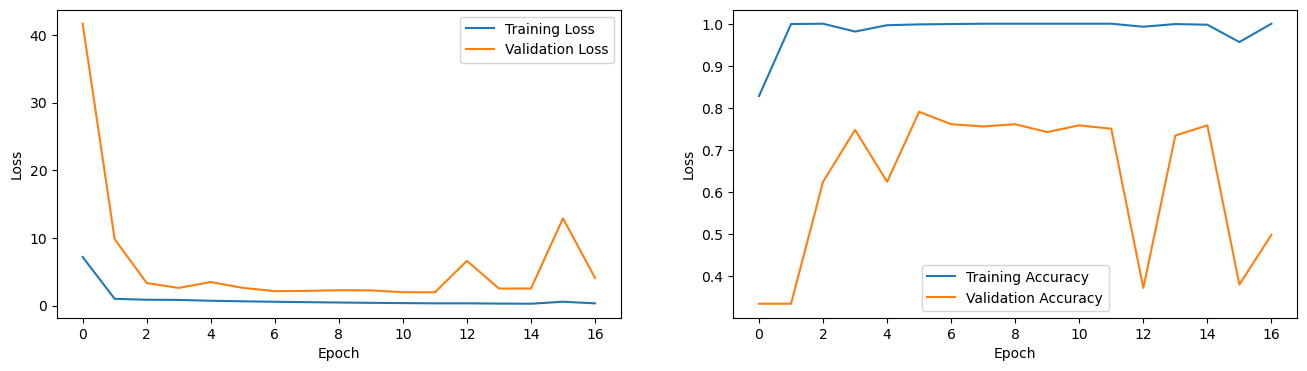

In [ ]:
# Hubo un pequeño overfitting, sin embargo hubo poca variación en el error entre el de set de validación y el de training. 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16, 4))

plt.subplot(121)
plt.plot(history1.history['loss'], label='Training Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(122)
plt.plot(history1.history['accuracy'], label='Training Accuracy')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [151]:
model1.save('firstModel.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━

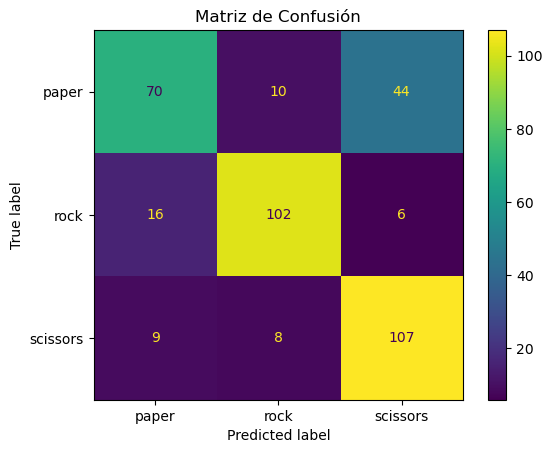

In [11]:
# Hacemos la matriz de Confusión
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import os

y_true = [] 
y_pred = [] 

base_dir = pathlib.Path("C:/Tec/Semestre 7/AI 1/ComputerVision/RPS/Rock-Paper-Scissors/test")
for class_index, class_name in enumerate(class_names):
    class_dir = base_dir / class_name
    for img_file in os.listdir(class_dir):
        img_path = class_dir / img_file
        img = image.load_img(img_path, target_size=(300, 300))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)

        predictions = n.predict(img_array)
        predicted_class = np.argmax(predictions, axis=-1)[0]

        y_true.append(class_index)
        y_pred.append(predicted_class) 

matrix = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=class_names)

disp.plot(cmap='viridis')
disp.ax_.set_title("Matriz de Confusión")

report = classification_report(y_true, y_pred, target_names=class_names)
print("\nInforme de Clasificación:")
print(report)

Con la matriz de confusión sue puede ver que el modelo tiene un accuracy de 0.75. La clase que más le costó trabajo fue la de piedra. Podemos ver que en las otras dos clases hubo buenos resultado pero aún así hubieron algunos errores.

In [ ]:
# Para el segundo modelo opté por una arquitectura con 4 capas convolucionales, utilizando activación ReLU, MaxPooling, BatchNormalization y L2 Regularization. Aumenté el tamaño del kernel a medida que avanzaba cada capa para capturar patrones más complejos. Finalmente, incluí una capa de Dropout al final para prevenir el overfitting, desactivando aleatoriamente neuronas durante el entrenamiento y mejorando la generalización del modelo. COmo se puede ver, este modelo es más simple que el primero ya que al ser muy compleja la red para un problema no tan complejo, la red no aprendía patrones significativos por lo cual en el primero se obtuvo un accuracy bajo
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
model = models.Sequential([
    layers.InputLayer(input_shape=(300, 300, 3)),  
    # 1era capa
    layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),  
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    # 2da capa
    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),  
    layers.MaxPooling2D((2, 2)),  
    layers.BatchNormalization(),

    # 3era capa
    layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)), 
    layers.MaxPooling2D((2, 2)), 
    layers.BatchNormalization(),

    #4ta capa
    layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),  
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)), 
    layers.Dense(3, activation='softmax')  
])

model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_23 (Conv2D)              │ (None, 298, 298, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 149, 149, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 149, 149, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 147, 147, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 73, 73, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 73, 73, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 71, 71, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 35, 35, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 35, 35, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 33, 33, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │    16,777,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,168,579 (65.49 MB)

 Trainable params: 17,167,619 (65.49 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
# Para el optimizador decidí mantenerlo igual al del primero modelo puesto que quiero mantener la misma cantidad de learning steps con ese mayor ajuste de pesos 
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [ ]:
# Para los callbacks usé un earlystopping con patience de 10 para darle mayor chance al modelo de mejorar y encontrarr una mejor solución, aumentando a lo que tenía en el primer modelo. Igual guardo el mejor modelo con el ModelCheckpiont
import keras
callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    keras.callbacks.ModelCheckpoint(filepath="improved_model.keras", save_best_only=True, monitor="val_loss")
]

In [125]:
# Entreno el modelo con 30 épocas para permitir un mayor ajuste de pesos a lo largo devarias iteraciones. No decidí usar más épocas ya que no creí que fuera necesario al no tratarse de un dataset demasiado complejo
history = model.fit(train_dataset, epochs=30, validation_data=validation_dataset, callbacks=callbacks)

Epoch 1/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - accuracy: 0.9700 - loss: 1.6586 - val_accuracy: 0.5833 - val_loss: 54.0322
Epoch 2/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - accuracy: 0.9956 - loss: 3.2141 - val_accuracy: 0.7446 - val_loss: 3.5973
Epoch 3/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - accuracy: 0.9998 - loss: 1.0996 - val_accuracy: 0.7849 - val_loss: 1.7556
Epoch 4/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - accuracy: 0.9970 - loss: 0.6808 - val_accuracy: 0.7339 - val_loss: 1.8020
Epoch 5/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 0.9927 - loss: 0.5586 - val_accuracy: 0.3763 - val_loss: 20.1391
Epoch 6/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/step - accuracy: 0.9962 - loss: 0.8475 - val_accuracy: 0.8441 - val_loss: 0.8200
Epoch 7/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/step - accuracy: 1.0000 - loss: 0.3369 - val_accuracy: 0.8925 - val_loss: 0.5501
Epoch 8/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - accuracy: 1.0000 - loss: 0.1668 - val_accuracy: 0.8763 - val_los

In [126]:
# Probamos el accuracy del modelo
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9388 - loss: 0.2824 
Test accuracy: 0.939


In [1]:
# Realizamos predicción con imagenes del set de test
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import pathlib


import numpy as np
base_dir = pathlib.Path("C:/Tec/Semestre 7/AI 1/ComputerVision/RPS/Rock-Paper-Scissors")
img_path = base_dir / 'test/rock/testrock01-11.png'

img = image.load_img(img_path, target_size=(300, 300))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

m = load_model('improvedModel.keras')

predictions = m.predict(img_array)

predicted_class = np.argmax(predictions, axis=-1)

class_names = ['paper', 'rock', 'scissors']
predicted_label = class_names[predicted_class[0]]

print(f"La predicción para la imagen es: {predicted_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step
La predicción para la imagen es: rock


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━

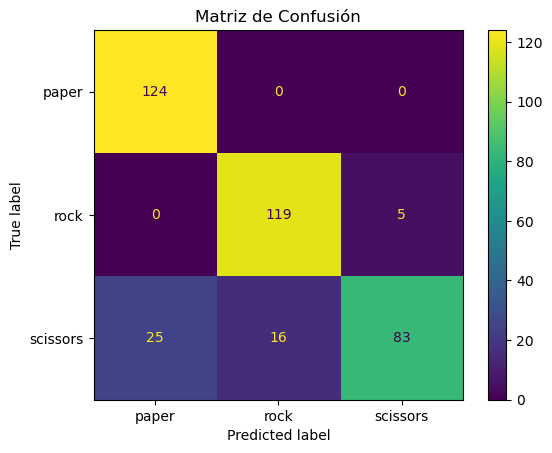

In [5]:
# Hacemos la matriz de Confusión
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import os

y_true = [] 
y_pred = [] 

base_dir = pathlib.Path("C:/Tec/Semestre 7/AI 1/ComputerVision/RPS/Rock-Paper-Scissors/test")
for class_index, class_name in enumerate(class_names):
    class_dir = base_dir / class_name
    for img_file in os.listdir(class_dir):
        img_path = class_dir / img_file
        img = image.load_img(img_path, target_size=(300, 300))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)

        predictions = m.predict(img_array)
        predicted_class = np.argmax(predictions, axis=-1)[0]

        y_true.append(class_index)
        y_pred.append(predicted_class) 

matrix = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=class_names)

disp.plot(cmap='viridis')
disp.ax_.set_title("Matriz de Confusión")

report = classification_report(y_true, y_pred, target_names=class_names)
print("\nInforme de Clasificación:")
print(report)

Analizando la Matriz de confusión, se puede ver que el modelo tiene un buen accuracy, de 0.85. Mejoró drásticamente a comparación del primer modelo. Tanto la clase papel como la de piedra son predichas correctamente, la de roca la predice sin errores y la de papel solo tiene 8 errores. Por otro lado, la clase de papel es la que más le cuesta al modelo. 

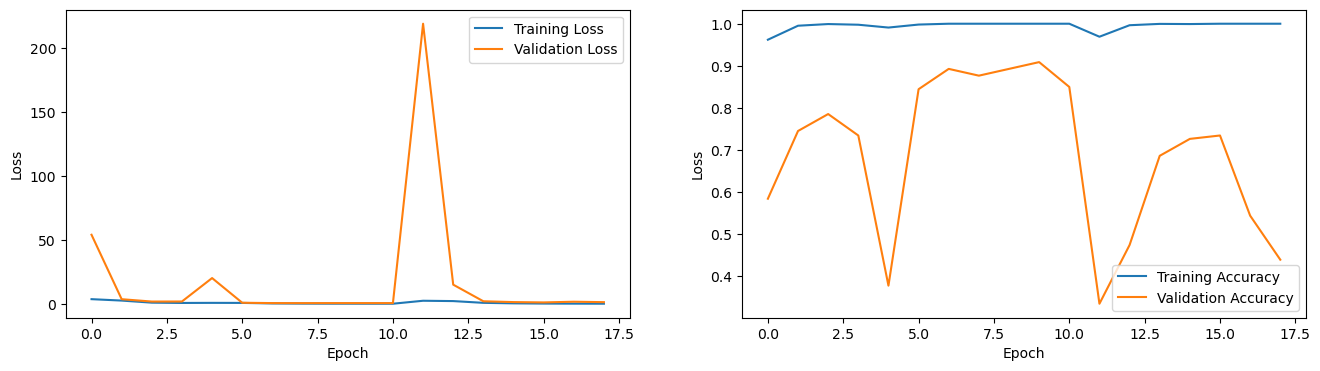

In [ ]:
# Analizando las gráficas se podría decir que el modelo cayó en un poco de overfitting, sin embargo, todas las pruebas con datos del conjunto de testing que se hicieron fueron exitosas. Después épocas el modelo fue desaprendiendo porque la validación del entrenamiento ya era muy alta por lo que no podía aprender más. Gracias al earlystopping se evitó que se corrieran las 30 épocas completas.
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16, 4))

plt.subplot(121)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(122)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
model.save('improvedModel.keras')


FileUpload(value=(), accept='image/*', description='Upload')

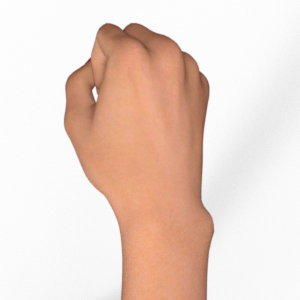

In [ ]:
# Celda para que el usuario pueda cargar su imagen y obtener una predicción

from IPython.display import display
import ipywidgets as widgets
from PIL import Image
import io

uploader = widgets.FileUpload(
    accept='image/*',
    multiple=False  
)

display(uploader)

def process_image(change):
    if uploader.value:
        for file_info in uploader.value: 
            try:
                file_content = file_info['content']  
            except (TypeError, KeyError):
                file_content = file_info.content  

            img = Image.open(io.BytesIO(file_content))
            display(img)

uploader.observe(process_image, names='value')


In [18]:
# COnvertimos la imagen que subió el usuario para que sea compatible con el modelo
import io

file_content = uploader.value[0]['content']

img = image.load_img(io.BytesIO(file_content), target_size=(300, 300))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

predictions = m.predict(img_array)

predicted_class = np.argmax(predictions, axis=-1)

class_names = ['paper', 'rock', 'scissors']
predicted_label = class_names[predicted_class[0]]

print(f"La predicción para la imagen es: {predicted_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
La predicción para la imagen es: rock


Conclusiones:
Después de observar los resultados de ambos modelos se puede concluir que no necesariamente el que un modelo sea más complejo significa que vaya a tener mejores resultados. EN este caso, al ser un dataset relativamente sencillo y con pocas clases, me di cuenta que el metyer demasiadas capas densas y con una regularización más estricta causaba que el modelo memorizara más el conjunto de datos de entrenamiento y le faltaran de aprender algunos patrones claves de las imagenes, lo que resultaba en un accuracy en el conjunto de validación más bajo. Es cierto que el segundo modelo, aunque obtuve mejores resultados, cayó en un poco de overfitting. Para la siguiente entrega se podría mejorar reduciendo un poco más la complejidad del modelo para así reducir el overfitting. Algunas ideas que se me vienen a la mente son el reducir el learning rate (actualmente .001) o hasta reducir la cantidad de capas de convolución (actualmente 4), de igual manerfa me gustaríoa seguir investigando que otros bloques o hiperparámetros son útiles para reducir problemas de overfitting, así como es el funcionamiento de las capas de Dropout.
De igual manera considero que el EarlyStopping es un factor fundamental a la hora de entrenar un modelo, ya que se le pude dar la oportunidad, o no, a un modelo de seguir ajustando sus pesos y encontrar mejores valores. Es indispensable encontrar un buen balance y no irse a los extremos (ni muy poco ni tanto), para así no tardar tanto en encontrar una solución óptima.
